# Content - road graph
1. Import a road graph from OSM on a given area
2. Clean the graph
3. Process graph to avoid main issues in modeling
4. Export nodes and links

In [1]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# OSMNX

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')

import geopandas as gpd
from shapely import geometry
import osmnx as ox
import geopandas as gpd
import os

from syspy.spatial.graph.graphbuilder import GraphBuilder, OsmnxCleaner
from syspy.spatial.graph import graphbuilder

training_folder = '../../'
input_folder = training_folder + r'inputs/'

In [3]:
if manual:
    %matplotlib inline
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

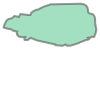

In [4]:
zones = gpd.read_file(r'../../inputs/zones/zones.geojson')
hull = geometry.MultiPolygon(zones['geometry'].values).buffer(1e-3)
hull

# OSMNX API

Download a road graph from a given area.  
Warning: the area coordinates must be given in lat-lon !

In [5]:
drive = ox.graph_from_polygon(hull, network_type='drive')

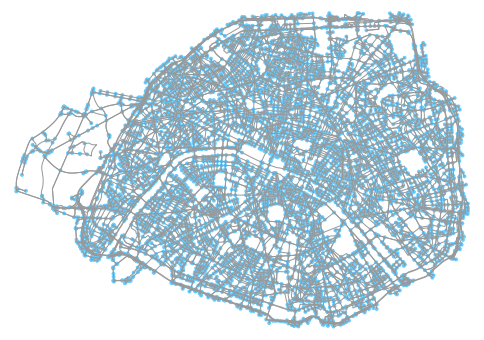

In [6]:
plot = ox.plot_graph(drive)

Export to GeoDataFrame

In [7]:
road_nodes, road_links = ox.graph_to_gdfs(drive)

Rename columns and reindex before processing

In [8]:
road_links.rename(columns={'u': 'from', 'v': 'to'}, inplace=True)
road_nodes['osmid'] = road_nodes['osmid'].astype(str)
road_nodes = road_nodes.set_index('osmid')[['geometry']]
road_links[['from', 'to']] = road_links[['from', 'to']].astype(str)

# cleaning

In [9]:
from shapely import geometry
def simplify_link(g):
    l = list(g.coords)
    return geometry.LineString([l[0], l[-1]])

In [10]:
road_links['geometry'] = road_links['geometry'].apply(simplify_link)

OsmnxCleaner is a syspy Class, that gives access to specific methods to clean the osm graph

In [11]:
oc = OsmnxCleaner(
    road_links, 
    road_nodes, 
    a='from', 
    b='to'
)

In [12]:
oc.add_reversed_links(
    direction_column='oneway', 
    reverse_value=False
)
oc.clean_geometries()
oc.fix_nodeset_consistency()

In [13]:
# drop duplicated links
oc.links['osmid_tuple'] = oc.links['osmid'].apply(lambda x: tuple(x) if isinstance(x, list) else tuple([x]))
oc.links = oc.links.drop_duplicates(subset=['a', 'b', 'osmid_tuple'])

# Integrity test

In [14]:
from quetzal.model.stepmodel import StepModel

sm = StepModel(epsg=4326, coordinates_unit='degree')
sm.road_links = oc.links[['a', 'b', 'length', 'geometry', 'highway']].copy()
sm.road_nodes = oc.nodes[['geometry']].copy()

SQLalchemy is not installed. No support for SQL output.


Find in the documentation (https://systragroup.github.io/quetzal/) :
- a method to test the road network integrity
- what the method integrity_fix_road_network does.

In [15]:
sm.integrity_test_road_network()

10411it [00:04, 2495.14it/s]


AssertionError: some directional road_links are dead-ends 
ex 1 : if their is an a->b link and their is no link leaving b; b is a dead-nodes 
ex 2 : in the given network (a->b, b->c, c->d, b->a) both c and d are dead-nodes 
because you can not reach 'a' from them 
the dead-rank of d is 0, the dead rank of c is 1 
dead-nodes: ['1513501834', '289568129', '28869429', '175015093', '253045949', '1393717976', '1770654184', '135578467', '27336532', '319834828', '15435237', '25554238', '638949372', '29414991', '27288873', '356195591', '5769665855', '271430776', '271430653', '693550591', '356195274', '27336534', '6750577095', '25273121', '25272987', '25272989', '25273204', '25273200', '264543892', '305964756', '633496401', '297707357', '29414990', '1502899155', '25288788', '168541315', '356301570', '451752147', '451752149', '249691272', '353192559', '319894847', '166417416', '268260176', '554937773', '826086259', '25240132', '168541314', '15032388', '34818812', '36487657', '268127166', '268127167', '257936407', '257936411', '353705100', '25554270', '487175880', '616883318', '25554421', '26039470', '303478451', '25554422', '26401640', '26401639', '15032421', '15032425', '212623968', '633496296', '267379813', '208499661', '320203180', '971501937', '27234844', '368204', '25554438', '25554701', '6638599300', '1393717979', '368471721']

In [16]:
sm.integrity_fix_road_network??

In [17]:
sm.integrity_fix_road_network(cutoff=10, recursive_depth=5)

direct: 10411it [00:04, 2403.34it/s]
reversed: 10411it [00:04, 2463.08it/s]
10225it [00:04, 2396.43it/s]


In [18]:
# Now it is working !
sm.integrity_test_road_network()

10225it [00:04, 2441.28it/s]


1. Analyse the number of links per category ('highway')
2. Remove road links that are in the following categories ['pedestrian', 'footway', 'service', 'cycleway', 'residential']

In [19]:
sm.road_links['highway'].astype(str).value_counts()

residential                                      9615
secondary                                        3005
primary                                          2963
tertiary                                         2661
unclassified                                      766
living_street                                     500
trunk_link                                        187
trunk                                             145
primary_link                                      135
secondary_link                                     45
['residential', 'living_street']                   44
['residential', 'unclassified']                    38
tertiary_link                                      24
['primary', 'tertiary']                             5
['tertiary', 'secondary']                           4
['tertiary', 'living_street']                       4
['primary', 'primary_link']                         4
['unclassified', 'living_street']                   3
['trunk_link', 'primary_link

In [20]:
sm.road_links['highway'] = sm.road_links['highway'].astype(str)
irrelevant = ['pedestrian', 'footway', 'service', 'cycleway', 'residential']
sm.road_links = sm.road_links.loc[~sm.road_links['highway'].isin(irrelevant)]

# Export

In [21]:
sm.to_json(input_folder + 'road', only_attributes=['road_links', 'road_nodes'])

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.75it/s]


Display road_links and road_nodes with a GIS software